In [292]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gurobipy as gp
from gurobipy import GRB

In [291]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [2]:
rng = np.random.default_rng(43)

# Bootstrap with Unobserved Tail

We observed a sample but assume there are values which remain unobserved (not neccessarily in the tail) that need to be considered.

Bootstrap confidence intervals on the proportion of values within the sample. However, these are not intervals for the probabilities of these values, but instead the ration of their probability to the total mass of the observed values:

In [26]:
# distribution with a tail
states = [0, 1, 2, 3, 4]
probs = [0.2, 0.2, 0.2, 0.2, 0.2]

In [27]:
# draw sample
x = rng.choice(states, 1000, p=probs)

# remove tail (unobserved)
x = x[x < 4]

In [32]:
# bootstrap

# bootstrap resamples
N = 1000

# resample size
n = len(x)

# estimates per resample
estimates = np.zeros((N, 4))
for i in range(N):

    # resample
    y = rng.choice(x, len(x))

    # estimate
    for j in range(4):
        estimates[i, j] = int((y == j).sum())

# quantiles
intervals = np.quantile(estimates, [0.025, 0.975], axis=0) / n

# display intervals
intervals

array([[0.2097561 , 0.23289634, 0.2402439 , 0.19878049],
       [0.26710366, 0.29271341, 0.30243902, 0.25490854]])

In [31]:
0.2 / (0.2 + 0.2 + 0.2 + 0.2)

0.25

The bootstrapped intervals do not contain the probability of a state p(x) = 0.2

Instead they contain the probability relative to the mass of observed states p(x) / (sum x = 1, 2, 3, 4 p(x)) = 0.25

# Optimization

- setup basic bootstrap, 2 versions: classic truncating and replacing with [0, 1] vs removing outside truncation
- setup optimization, 2 versions: classic p in CI vs p / sum p in CI
- compare results

In [226]:
def bootstrap(sample, N, tau, drop=False):
    """
    Bootstrap estimate of probabilities of all states in the sample
    Set bounds outside tau threshold truncation to [0, 1]

    sample: integer sample
    N: number of bootstrap resamples
    tau: truncation threshold
    drop: if true, values outside truncation are removed from the sample before bootstrap
    """

    # OB truncation bounds
    xmin, xmax = int(sample.min()), int(sample.max())
    sample_counts = np.bincount(sample, minlength=(xmax + 1))
    t_indices = np.where(sample_counts > tau)[0]
    tmin, tmax = int(t_indices.min()), int(t_indices.max())

    # if drop: remove values outside the truncation before bootstrapping
    if drop:
        sample = sample[sample >= tmin]
        sample = sample[sample <= tmax]

    # bootstrap
    intervals = np.empty((2, xmax + 1))
    intervals[0, :] = 0
    intervals[1, :] = 1

    # resample
    resamples = rng.choice(sample, size=(N, len(sample)))
    # estimate over truncation
    for x in range(tmin, tmax + 1):
        # proportion of x per resample
        estimates = (resamples == x).mean(axis=1)
        # interval
        intervals[:, x] = np.quantile(estimates, [0.025, 0.975])

    return tmin, tmax, intervals

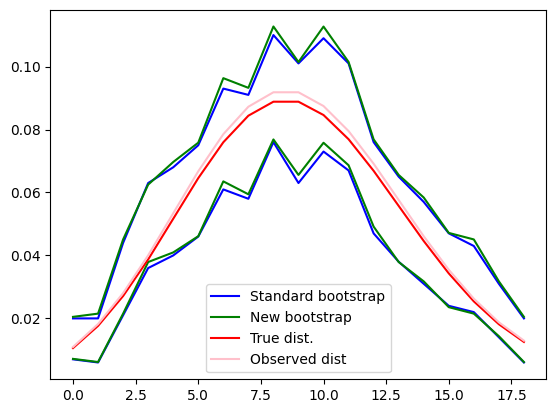

In [289]:
k = 20
tau = 10
N = 1000
n = 1000

sample = rng.poisson(k, size=n)
tmin, tmax, intervals_standard = bootstrap(sample, N, tau, drop=False)
tmin, tmax, intervals_drop = bootstrap(sample, N, tau, drop=True)
plt.plot(intervals_standard[0, tmin:tmax+1], color="blue", label="Standard bootstrap")
plt.plot(intervals_standard[1, tmin:tmax+1], color="blue")
plt.plot(intervals_drop[0, tmin:tmax+1], color="green", label="New bootstrap")
plt.plot(intervals_drop[1, tmin:tmax+1], color="green")

poi = scipy.stats.poisson.pmf(range(tmin, tmax + 1), k)
poi_obs = poi / sum(poi)

plt.plot(poi, color="red", label="True dist.")
plt.plot(poi_obs, color="pink", label="Observed dist")
plt.legend()

In [333]:
def optimize(tmin, tmax, intervals, silent=True, printing=True, time_limit=300):
    
    # WLS license
    options = {}# json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(tmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probability bounds
            model.addConstr(p <= intervals[1, :(tmax+1)], name="prob_UB")
            model.addConstr(p >= intervals[0, :(tmax+1)], name="prob_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, tmax)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            p_bounds = np.zeros((tmax + 1, 2))
            for x in range(tmax + 1):
                model.setObjective(p[x], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 1] = model.ObjVal
                except:
                    p_bounds[x, 1] = -1

                model.setObjective(p[x], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 0] = model.ObjVal
                except:
                    p_bounds[x, 0] = -1

            # store
            solution['p'] = p_bounds

    return solution

In [381]:
k = 10
tau = 10
N = 1000
n = 1000

sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=False)
solution = optimize(tmin, tmax, intervals)

k_tx in (9.739673843561102, 10.270594054687171), status OPTIMAL, OPTIMAL


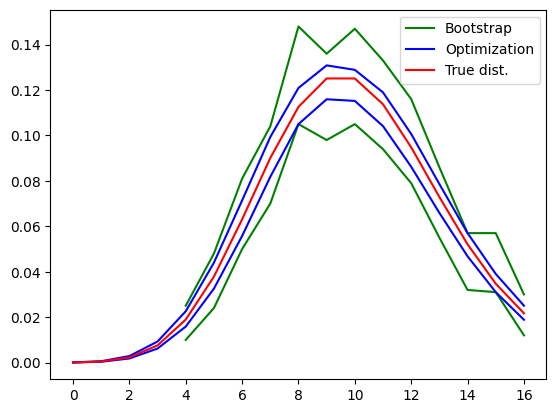

In [382]:
intervals_plot = intervals
intervals_plot[:, :tmin] = None
intervals_plot[:, (tmax+1):] = None
plt.plot(intervals_plot[0, :], color="green", label="Bootstrap")
plt.plot(intervals_plot[1, :], color="green")
plt.plot(solution['p'][:, 0], color="blue", label="Optimization")
plt.plot(solution['p'][:, 1], color="blue")
poi = scipy.stats.poisson.pmf(range(tmax + 1), k)
plt.plot(poi, color="red", label="True dist.")
plt.legend()

In [ ]:
def optimize_new(tmin, tmax, intervals, silent=True, printing=True, time_limit=300):
    
    # WLS license
    options = {}# json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(tmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probability bounds
            p_obs = p.sum()
            model.addConstr(p <= intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p >= intervals[0, :(tmax+1)] * p_obs, name="prob_LB") # lower bound * p_obs is causing the wider results

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, tmax)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            p_bounds = np.zeros((tmax + 1, 2))
            for x in range(tmax + 1):
                model.setObjective(p[x], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 1] = model.ObjVal
                except:
                    p_bounds[x, 1] = -1

                model.setObjective(p[x], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 0] = model.ObjVal
                except:
                    p_bounds[x, 0] = -1

            # store
            solution['p'] = p_bounds

    return solution

In [415]:
k = 1
tau = 10
N = 1000
n = 1000

sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)
solution = optimize_new(tmin, tmax, intervals)

k_tx in (0.0, 100.0), status OPTIMAL, OPTIMAL


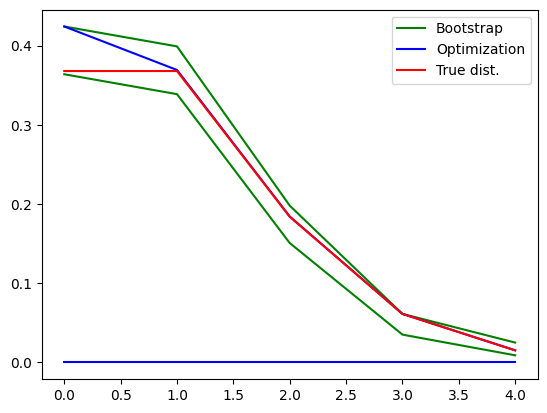

In [416]:
intervals_plot = intervals
intervals_plot[:, :tmin] = None
intervals_plot[:, (tmax+1):] = None
plt.plot(intervals_plot[0, :], color="green", label="Bootstrap")
plt.plot(intervals_plot[1, :], color="green")
plt.plot(solution['p'][:, 0], color="blue", label="Optimization")
plt.plot(solution['p'][:, 1], color="blue")
poi = scipy.stats.poisson.pmf(range(tmax + 1), k)
plt.plot(poi, color="red", label="True dist.")
plt.legend()